In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [3]:
num_epochs = 25
percentage_of_train_dataset = 0.20 #Out of 60K Image (To Speed up Training)
percentage_of_test_dataset = 0.20 # Out of 10K Images (To Speed up Testing)


loss_history =[]
acc_history =[]
min_loss = 9999 #To implement Simple Early Stopping
no_improvement_epoch = 0 #To implement Simple Early Stopping


https://github.com/deepinsight/insightface/blob/master/recognition/arcface_torch/losses.py

In [4]:
class ArcLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, scale=2.0, margin=3.0):
        super(ArcLoss, self).__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.scale = scale
        self.margin = margin
        self.threshold = torch.cos(torch.tensor(np.pi - margin))
        margin = torch.Tensor([margin])
        self.cos_m = torch.cos(margin)
        self.sin_m = torch.sin(margin)
        

        self.weights = nn.Parameter(torch.randn(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weights)

    def forward(self, inputs, labels):
        # Normalize feature vectors
        logits = F.normalize(inputs, p=2, dim=1)
        weights = F.normalize(self.weights, p=2, dim=1)

        # Compute cosine similarity
        cosine_similarity = torch.matmul(logits, weights.to(device))

        # Compute arc cosine
        arc = torch.acos(torch.clamp(cosine_similarity, -1.0 + torch.finfo(torch.float32).eps, 1.0 - torch.finfo(torch.float32).eps))

        # Compute arcface loss
        target_cos = torch.cos(arc + self.margin)
        one_hot = torch.zeros_like(cosine_similarity)
        one_hot.scatter_(1, labels.view(-1, 1), 1)
        output = one_hot * target_cos + (1.0 - one_hot) * cosine_similarity
        output *= self.scale

        return F.cross_entropy(output, labels).mean()

In [5]:
# Data Augmentation and Normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [6]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.CIFAR10(root='./cifar_data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./cifar_data', train=False, transform=transform_test, download=True)

indices = np.arange(len(train_dataset))
indices2 = np.arange(len(test_dataset))

train_indices, _ = train_test_split(indices, train_size=percentage_of_train_dataset, stratify=train_dataset.targets)
test_indices, _ = train_test_split(indices2, train_size=percentage_of_test_dataset, stratify=test_dataset.targets)

# Warp into Subsets and DataLoaders
train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:

# Define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = x.view(-1, 512)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [8]:
model = Net()
model.to(device)

# Define ArcLoss criterion and optimizer
criterion = ArcLoss(num_classes=10, embedding_size=512)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

Printing Model Parameter

In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.mean())

conv1.weight tensor(-0.0012, device='cuda:0')
conv1.bias tensor(0.0034, device='cuda:0')
bn1.weight tensor(1., device='cuda:0')
bn1.bias tensor(0., device='cuda:0')
conv2.weight tensor(3.1485e-05, device='cuda:0')
conv2.bias tensor(0.0020, device='cuda:0')
bn2.weight tensor(1., device='cuda:0')
bn2.bias tensor(0., device='cuda:0')
conv3.weight tensor(1.7434e-05, device='cuda:0')
conv3.bias tensor(0.0009, device='cuda:0')
bn3.weight tensor(1., device='cuda:0')
bn3.bias tensor(0., device='cuda:0')
conv4.weight tensor(-5.3350e-06, device='cuda:0')
conv4.bias tensor(0.0015, device='cuda:0')
bn4.weight tensor(1., device='cuda:0')
bn4.bias tensor(0., device='cuda:0')
conv5.weight tensor(3.7781e-06, device='cuda:0')
conv5.bias tensor(-0.0001, device='cuda:0')
bn5.weight tensor(1., device='cuda:0')
bn5.bias tensor(0., device='cuda:0')
fc1.weight tensor(1.9077e-06, device='cuda:0')
fc1.bias tensor(-0.0006, device='cuda:0')
fc2.weight tensor(3.3975e-05, device='cuda:0')
fc2.bias tensor(0.0005, d

In [10]:

# Training loop
for epoch in range(num_epochs):

    model.train()
    avg_loss = 0
    loop_count = 0

    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(images.to(device))
        loss = criterion(output, labels.to(device))
        # print("op:", output, type(output), output.shape)
        # print("lb:", labels, type(labels), labels.shape)
        loss.backward()
        optimizer.step()
        
        loop_count +=1
        avg_loss += loss.tolist()

    avg_loss /= loop_count
    print("Avg Loss:", avg_loss)

    loss_history.append(avg_loss)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            output = model(images.to(device))
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            # print(predicted.shape, labels.shape)
            correct += (predicted == labels.to(device)).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

    acc_history.append(accuracy)


    if avg_loss < min_loss:
        min_loss = avg_loss
        # print("Model Improved")
        no_improvement_epoch = 0
    else:
        # print("No Improvement")
        no_improvement_epoch += 1
    
    if no_improvement_epoch > 10:
        print("Early Stopping, No Improvement since few Epochs")
        break


print('Training Finished')

100%|██████████| 79/79 [00:06<00:00, 12.20it/s]


Avg Loss: 6.425251731389685


100%|██████████| 16/16 [00:00<00:00, 36.62it/s]


Epoch [1/25], Test Accuracy: 6.70%


100%|██████████| 79/79 [00:05<00:00, 15.53it/s]


Avg Loss: 6.39965361583082


100%|██████████| 16/16 [00:00<00:00, 35.37it/s]


Epoch [2/25], Test Accuracy: 5.30%


100%|██████████| 79/79 [00:05<00:00, 15.19it/s]


Avg Loss: 6.384594380101071


100%|██████████| 16/16 [00:00<00:00, 37.95it/s]


Epoch [3/25], Test Accuracy: 3.65%


100%|██████████| 79/79 [00:05<00:00, 15.70it/s]


Avg Loss: 6.373016091841686


100%|██████████| 16/16 [00:00<00:00, 38.14it/s]


Epoch [4/25], Test Accuracy: 4.10%


100%|██████████| 79/79 [00:05<00:00, 15.08it/s]


Avg Loss: 6.3670074668111685


100%|██████████| 16/16 [00:00<00:00, 36.75it/s]


Epoch [5/25], Test Accuracy: 4.95%


100%|██████████| 79/79 [00:05<00:00, 14.96it/s]


Avg Loss: 6.360312045375003


100%|██████████| 16/16 [00:00<00:00, 36.61it/s]


Epoch [6/25], Test Accuracy: 6.00%


100%|██████████| 79/79 [00:05<00:00, 15.23it/s]


Avg Loss: 6.355719409411466


100%|██████████| 16/16 [00:00<00:00, 36.58it/s]


Epoch [7/25], Test Accuracy: 4.55%


100%|██████████| 79/79 [00:05<00:00, 15.36it/s]


Avg Loss: 6.351122741457782


100%|██████████| 16/16 [00:00<00:00, 37.77it/s]


Epoch [8/25], Test Accuracy: 6.80%


100%|██████████| 79/79 [00:05<00:00, 15.15it/s]


Avg Loss: 6.349096581905703


100%|██████████| 16/16 [00:00<00:00, 36.08it/s]


Epoch [9/25], Test Accuracy: 7.80%


100%|██████████| 79/79 [00:05<00:00, 15.33it/s]


Avg Loss: 6.345229698132865


100%|██████████| 16/16 [00:00<00:00, 36.98it/s]


Epoch [10/25], Test Accuracy: 7.40%


100%|██████████| 79/79 [00:05<00:00, 15.40it/s]


Avg Loss: 6.3430404482008536


100%|██████████| 16/16 [00:00<00:00, 36.95it/s]


Epoch [11/25], Test Accuracy: 8.35%


100%|██████████| 79/79 [00:05<00:00, 14.96it/s]


Avg Loss: 6.340111647980122


100%|██████████| 16/16 [00:00<00:00, 36.78it/s]


Epoch [12/25], Test Accuracy: 9.20%


100%|██████████| 79/79 [00:05<00:00, 14.94it/s]


Avg Loss: 6.3379406083988234


100%|██████████| 16/16 [00:00<00:00, 35.69it/s]


Epoch [13/25], Test Accuracy: 8.40%


100%|██████████| 79/79 [00:05<00:00, 15.18it/s]


Avg Loss: 6.3343388702296


100%|██████████| 16/16 [00:00<00:00, 36.63it/s]


Epoch [14/25], Test Accuracy: 8.25%


100%|██████████| 79/79 [00:05<00:00, 14.99it/s]


Avg Loss: 6.335598311846769


100%|██████████| 16/16 [00:00<00:00, 35.72it/s]


Epoch [15/25], Test Accuracy: 8.10%


100%|██████████| 79/79 [00:05<00:00, 14.94it/s]


Avg Loss: 6.332350459279893


100%|██████████| 16/16 [00:00<00:00, 37.19it/s]


Epoch [16/25], Test Accuracy: 8.55%


100%|██████████| 79/79 [00:05<00:00, 15.00it/s]


Avg Loss: 6.3304414507708975


100%|██████████| 16/16 [00:00<00:00, 37.03it/s]


Epoch [17/25], Test Accuracy: 9.75%


100%|██████████| 79/79 [00:05<00:00, 15.13it/s]


Avg Loss: 6.327664236479167


100%|██████████| 16/16 [00:00<00:00, 36.79it/s]


Epoch [18/25], Test Accuracy: 8.00%


100%|██████████| 79/79 [00:05<00:00, 14.96it/s]


Avg Loss: 6.326975743981857


100%|██████████| 16/16 [00:00<00:00, 35.75it/s]


Epoch [19/25], Test Accuracy: 8.25%


100%|██████████| 79/79 [00:05<00:00, 14.94it/s]


Avg Loss: 6.3252841671810875


100%|██████████| 16/16 [00:00<00:00, 37.00it/s]


Epoch [20/25], Test Accuracy: 7.75%


100%|██████████| 79/79 [00:05<00:00, 14.98it/s]


Avg Loss: 6.324834883967532


100%|██████████| 16/16 [00:00<00:00, 37.27it/s]


Epoch [21/25], Test Accuracy: 9.10%


100%|██████████| 79/79 [00:05<00:00, 14.86it/s]


Avg Loss: 6.323494482643997


100%|██████████| 16/16 [00:00<00:00, 37.01it/s]


Epoch [22/25], Test Accuracy: 7.95%


100%|██████████| 79/79 [00:05<00:00, 15.03it/s]


Avg Loss: 6.32118233547935


100%|██████████| 16/16 [00:00<00:00, 35.70it/s]


Epoch [23/25], Test Accuracy: 8.50%


100%|██████████| 79/79 [00:05<00:00, 14.91it/s]


Avg Loss: 6.321279525756836


100%|██████████| 16/16 [00:00<00:00, 36.63it/s]


Epoch [24/25], Test Accuracy: 8.45%


100%|██████████| 79/79 [00:05<00:00, 15.01it/s]


Avg Loss: 6.3208850003496


100%|██████████| 16/16 [00:00<00:00, 35.08it/s]

Epoch [25/25], Test Accuracy: 9.75%
Training Finished


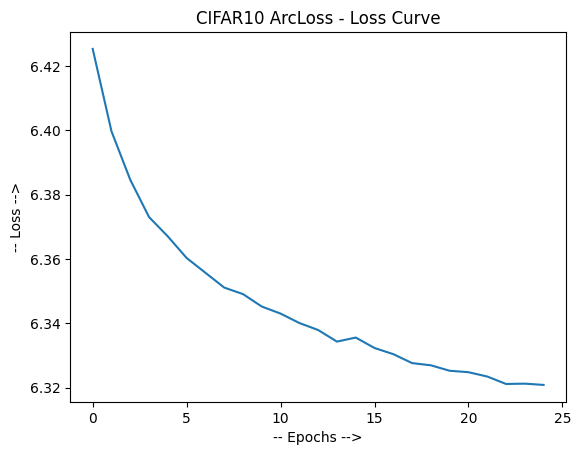

In [11]:
plt.plot(loss_history)
plt.title("CIFAR10 ArcLoss - Loss Curve")
plt.xlabel("-- Epochs -->")
plt.ylabel("-- Loss -->")
plt.savefig("arcloss_cifar10_loss.png")
plt.show()

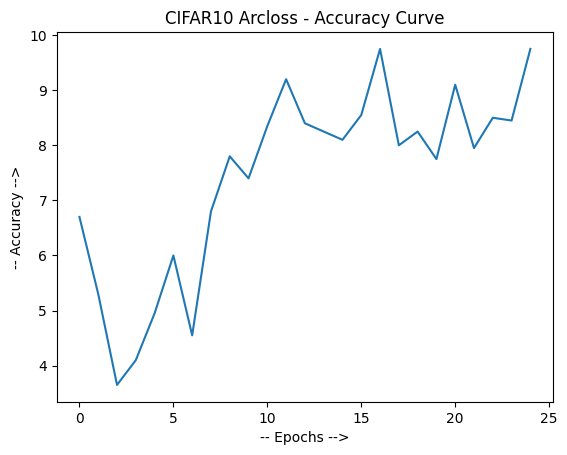

In [12]:
plt.plot(acc_history)
plt.title("CIFAR10 Arcloss - Accuracy Curve")
plt.xlabel("-- Epochs -->")
plt.ylabel("-- Accuracy -->")
plt.savefig("arcloss_cifar10_accuracy.png")
plt.show()

In [13]:
# Model accuracy testing
model.eval()
correct = 0
total = 0
optimizer.zero_grad()
with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing"):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the CIFAR10 test set: {(100 * correct / total):.2f}%")

Testing: 100%|██████████| 16/16 [00:00<00:00, 36.29it/s]

Accuracy on the CIFAR10 test set: 9.75%


In [14]:
# Test the Model

all_labels = []
all_predicted = []

with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        labels = labels.to(device)
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        
        for lbl in labels.tolist():
            all_labels.append(lbl)

        for pred in predicted.tolist():
            all_predicted.append(pred)

accuracy = metrics.accuracy_score(all_labels, all_predicted)
precision = metrics.precision_score(all_labels, all_predicted, average="weighted")
print("Accuracy:", accuracy)
print("Precision:", precision)

100%|██████████| 16/16 [00:00<00:00, 33.10it/s]

Accuracy: 0.0975
Precision: 0.15524598848828985



c:\Users\91997\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


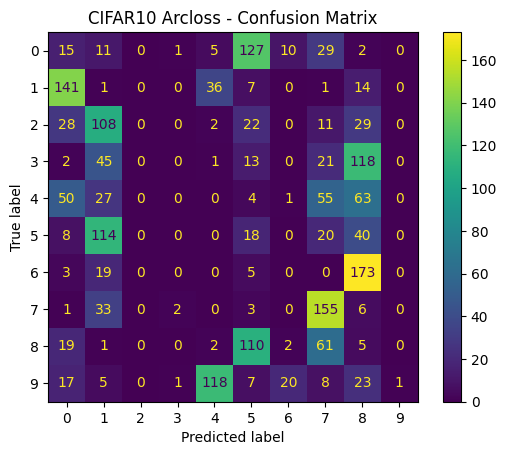

In [15]:
confusion_matrix = metrics.confusion_matrix(all_labels, all_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.title("CIFAR10 Arcloss - Confusion Matrix")
plt.savefig("arcloss_cifar10_cm.png")
plt.show()